In [1]:
import pickle
from os import listdir
import pandas as pd
from urllib.parse import urlparse
from collections import Counter
from tqdm import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
platform_dict = {
    'alfa_dict.p': "alfahir.hu",
    'dict_444.p': "444.hu",
    'hu24_dict.p': "24.hu",
    'hvg_dict.p': "hvg.hu",
    'index_dict.p': "index.hu",
    'kurucinfo_dict.p': "kuruc.info",
    'magyar_hirlap.p': "magyarhirlap.hu",
    'magyar_idok_dict.p': "magyarnemzet.hu",
    'magyar_nemzet_dict.p': "magyarnemzet.hu",
    'origo.p': "origo.hu",
    'zsurpubi_dict.p': "zsurpubi.hu"
}

In [3]:
files = [f for f in listdir(".\\") if f[-1] == "p"]
files

['alfa_dict.p',
 'dict_444.p',
 'hu24_dict.p',
 'hvg_dict.p',
 'index_dict.p',
 'kurucinfo_dict.p',
 'magyar_hirlap.p',
 'magyar_idok_dict.p',
 'magyar_nemzet_dict.p',
 'origo.p',
 'zsurpubi_dict.p']

In [4]:
df_list = []
for file in files:
    with open(file, 'rb') as f:
        x = pickle.load(f)
        for item in x:
            x[item]["platform"] = platform_dict[file]
        df = pd.DataFrame.from_dict(data = x, orient = 'index').reset_index()
        condition = df["publish_date"].str.contains('2019', na = False)
        df = df.loc[condition]
        print(file, ": ", len(x), len(df))
        df_list.append(df)

alfa_dict.p :  9014 8984
dict_444.p :  16681 16379
hu24_dict.p :  90365 32692
hvg_dict.p :  41123 40600
index_dict.p :  52479 52479
kurucinfo_dict.p :  149961 12913
magyar_hirlap.p :  23671 23627
magyar_idok_dict.p :  4416 4416
magyar_nemzet_dict.p :  39910 39909
origo.p :  53370 52168
zsurpubi_dict.p :  2929 2929


In [5]:
def hostname_parser(url):
    hostname_list = [urlparse(element).hostname if element != "MTI" else "MTI" for element in url]
    hostname_list = [host.replace("www.","") if host is not None else host for host in hostname_list]
    hostname_list = ["index.hu" if host == "dex.hu" is not None else host for host in hostname_list]
    hostname_list = ["twitter.com" if host == "t.co" is not None else host for host in hostname_list]
    hostname_list = ["magyarnemzet.hu" if host == "magyaridok.hu" is not None else host for host in hostname_list]
    return hostname_list

In [6]:
df = pd.concat(df_list, sort = False)
df["related_hosts"] = [hostname_parser(url) for url in df["related_links"]]
df = df[["index", 
         "platform", 
         "publish_date", 
         "related_links", 
         "related_hosts"]]

In [7]:
platforms = list(df["platform"].unique())
platforms

['alfahir.hu',
 '444.hu',
 '24.hu',
 'hvg.hu',
 'index.hu',
 'kuruc.info',
 'magyarhirlap.hu',
 'magyarnemzet.hu',
 'origo.hu',
 'zsurpubi.hu']

In [8]:
platform_count = {}
for platform in platforms:
    hosts = df[df["platform"] == platform]["related_hosts"]
    result_distinct = list(x for l in hosts for x in l)
    platform_count[platform] = dict(Counter(result_distinct))

In [9]:
dict(Counter(result_distinct).most_common(50))

{'zsurpubi.hu': 1263,
 'MTI': 174,
 '24.hu': 99,
 'facebook.com': 91,
 '444.hu': 89,
 'youtube.com': 63,
 'index.hu': 54,
 'twitter.com': 50,
 'nepszava.hu': 49,
 'hvg.hu': 47,
 'parlament.hu': 45,
 'magyarhang.org': 27,
 'instagram.com': 22,
 'mfor.hu': 22,
 'alfahir.hu': 18,
 'napi.hu': 16,
 'magyarnemzet.hu': 12,
 'police.hu': 11,
 'g7.hu': 11,
 'magyarnarancs.hu': 10,
 'valaszonline.hu': 9,
 'kormany.hu': 9,
 'blog.atlatszo.hu': 9,
 'mandiner.hu': 8,
 'atlatszo.hu': 8,
 'hu.euronews.com': 8,
 '168ora.hu': 7,
 'atv.hu': 7,
 'origo.hu': 6,
 'merce.hu': 6,
 'ezazordogugyvedje.wordpress.com': 6,
 'azonnali.hu': 6,
 'portfolio.hu': 5,
 'mte.hu': 5,
 'hu.wikipedia.org': 5,
 'pecsistop.hu': 5,
 'magyarkozlony.hu': 5,
 'vg.hu': 5,
 'figyelo.hu': 5,
 'spiegel.de': 4,
 'hirado.hu': 4,
 'fidesz.hu': 4,
 'hirtv.hu': 4,
 'qubit.hu': 4,
 'docs.google.com': 4,
 'pornhub.com': 4,
 'mek.oszk.hu': 4,
 'politico.eu': 4,
 'welt.de': 4,
 'nyugat.hu': 4}

# Calculating the sum of references for each portal

In [10]:
reference_counter = {}
for key in platform_count.keys():
    summa = 0
    for sub_key in platform_count[key]:
        summa += platform_count[key][sub_key]
    reference_counter[key] = summa
reference_counter

{'alfahir.hu': 11522,
 '444.hu': 39086,
 '24.hu': 57915,
 'hvg.hu': 80918,
 'index.hu': 835445,
 'kuruc.info': 28256,
 'magyarhirlap.hu': 19996,
 'magyarnemzet.hu': 45754,
 'origo.hu': 58292,
 'zsurpubi.hu': 2620}

In [11]:
article_counter = df.groupby('platform')['index'].nunique().to_dict()
article_counter

{'24.hu': 32692,
 '444.hu': 16379,
 'alfahir.hu': 8984,
 'hvg.hu': 40600,
 'index.hu': 52479,
 'kuruc.info': 12913,
 'magyarhirlap.hu': 23627,
 'magyarnemzet.hu': 44321,
 'origo.hu': 52168,
 'zsurpubi.hu': 2929}

In [12]:
ref_ratio = {}
for portal in article_counter:
    ref_ratio[portal] = reference_counter[portal] / article_counter[portal]
ref_ratio

{'24.hu': 1.7715343203230147,
 '444.hu': 2.3863483729165393,
 'alfahir.hu': 1.2825022261798753,
 'hvg.hu': 1.9930541871921181,
 'index.hu': 15.91960593761314,
 'kuruc.info': 2.188182451792767,
 'magyarhirlap.hu': 0.8463198882634274,
 'magyarnemzet.hu': 1.0323323029715032,
 'origo.hu': 1.1173899708633646,
 'zsurpubi.hu': 0.8945032434277911}

In [13]:
reference_per_articles_ratios = pd.DataFrame.from_dict(ref_ratio, orient='index')

# Önhivatkozás aránya

In [14]:
platform_count = {}
for platform in platforms:
    hosts = df[df["platform"] == platform]["related_hosts"]
    result_distinct = list(x for l in hosts for x in l)
    platform_count[platform] = dict(Counter(result_distinct))

In [15]:
homophily_ratios = {}
for portal in reference_counter:
    homophily_ratios[portal] = platform_count[portal][portal] / reference_counter[portal]
homophily_ratios = {k: v for k, v in sorted(homophily_ratios.items(), key=lambda item: item[1])}

In [16]:
homophily_values = list(homophily_ratios.values())
portal_names = list(homophily_ratios.keys())
barWidth = 0.75

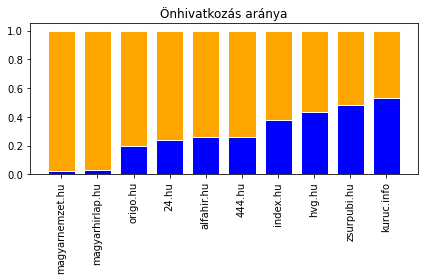

In [17]:
fig = plt.figure()
plt.bar(range(10), homophily_values, color='blue', edgecolor='white', width = barWidth)
plt.bar(range(10), 
        [a_i - b_i for a_i, b_i in zip([1] * 10, homophily_values)], 
        bottom = homophily_values, 
        color='orange', 
        edgecolor='white', 
        width=barWidth)
plt.xticks(range(10), portal_names)
plt.xticks(rotation = 90)
plt.title("Önhivatkozás aránya")
plt.tight_layout()
fig.savefig('homophily_ratio.png', dpi = 2000)

# A top 10 hivatkozás hány százalékot fed le az összesből

In [18]:
platform_count_t10 = {}
for platform in platforms:
    hosts = df[df["platform"] == platform]["related_hosts"]
    result_distinct = list(x for l in hosts for x in l)
    platform_count_t10[platform] = dict(Counter(result_distinct).most_common(10))

In [19]:
top10_ratio = {}
for platform in platform_count_t10:
    summa = 0
    for referee in platform_count_t10[platform]:
        summa += platform_count_t10[platform][referee]
    top10_ratio[platform] = summa / reference_counter[platform]
top10_ratio = {k: v for k, v in sorted(top10_ratio.items(), key=lambda item: item[1])}

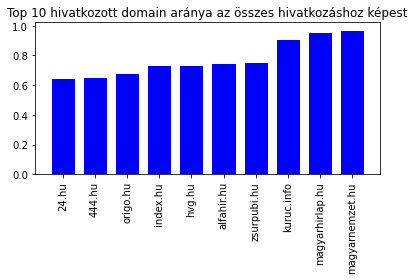

In [20]:
fig = plt.figure()
plt.bar(range(10), top10_ratio.values(), color='blue', edgecolor='white', width = barWidth)

plt.xticks(range(10), top10_ratio.keys())
plt.xticks(rotation = 90)
plt.title("Top 10 hivatkozott domain aránya az összes hivatkozáshoz képest")
plt.tight_layout()
fig.savefig('top10_ratio.png', dpi = 2000)

# Hivatkozások fundamentális elemzése (top 10 hivatkozott per médium)

In [21]:
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
platform_count_top10 = {}
for platform in platforms:
    hosts = df[df["platform"] == platform]["related_hosts"]
    result_distinct = list(x for l in hosts for x in l)
    if platform != "index.hu":
        print(platform)
        platform_count_top10[platform] = dict(Counter(result_distinct).most_common(10))
        platform_df = pd.DataFrame.from_dict(data = platform_count_top10[platform], 
                                             orient = 'index').reset_index().rename(columns = {0: "ref_count", "index": "portal"})
        fig = go.Figure()
        fig = px.bar(platform_df, x = "ref_count", y = "portal", orientation='h')
        fig.update_layout(
            title = f"{platform} top 10 hivatkozása",
            xaxis_title = "Hivatkozások száma",
            yaxis_title = "Hivatkozott weboldal"
        )
        fig.write_image(f"top10_{platform}.png")
        #fig.show()
    else:
        platform_count_top10[platform] = dict(Counter(result_distinct).most_common(12))
        #print(platform_count_top15.keys())
        del platform_count_top10[platform]['thesmokinggun.com']
        del platform_count_top10[platform]['ajanlat.indamediasales.hu']
        platform_df = pd.DataFrame.from_dict(data = platform_count_top10[platform], 
                                             orient = 'index').reset_index().rename(columns = {0: "ref_count", "index": "portal"})
        fig = go.Figure()
        fig = px.bar(platform_df, x = "ref_count", y = "portal", orientation='h')
        fig.update_layout(
            title = f"{platform} top 10 hivatkozása",
            xaxis_title = "Hivatkozások száma",
            yaxis_title = "Hivatkozott weboldal"
        )
        fig.write_image(f"top10_{platform}.png")
        fig.show()

alfahir.hu


In [ ]:
categories = {
    "alfahir.hu": "szelsojobb",
    "MTI": "MTI",
    "twitter.com": "kozossegi",
    "facebook.com": "kozossegi",
    "index.hu": "balos",
    "444.hu": "balos",
    "24.hu": "balos",
    "hvg.hu": "balos",
    "nepszava.hu": "balos",
    "parlament.hu": "szerv",
    "youtube.com": "kozossegi",
    "bbc.com": "kulfoldi",
    "theguardian.com": "kulfoldi",
    "streamable.com": "kozossegi",
    "instagram.com": "kozossegi",
    "police.hu": "szerv",
    "edition.cnn.com": "kulfoldi",
    "thesmokinggun.com": "kulfoldi",
    "ajanlat.indamediasales.hu": "kozossegi",
    "kuruc.info": "szelsojobb",
    "magyarharcos.hu": "szelsojobb",
    "en.wikipedia.org": "MTI",
    "turania.hu": "szelsojobb",
    "magyarhirlap.hu": "kormany",
    None: "kozossegi",
    "budapestpark.hu": "kozossegi",
    "mnb.hu": "szerv",
    "valasztas.hu": "szerv",
    "politico.eu": "kulfoldi",
    "magyarnemzet.hu": "kormany",
    "hirtv.hu": "kormany",
    "echotv.hu": "kormany",
    "origo.hu": "kormany",
    "tuzfalcsoport.blogstar.hu": "kormany",
    "pestisracok.hu": "kormany",
    "hirado.hu": "kormany",
    "katasztrofavedelem.hu": "szerv",
    "borsonline.hu": "kozossegi",
    "zsurpubi.hu": "szelsojobb"
}

In [ ]:
category_colour = {"szelsojobb": "Black",
                  "kozossegi": "Blue",
                  "kormany": "DarkOrange",
                  "szerv": "Gray",
                  "MTI": "LightSkyBlue",
                  "balos": "MediumPurple",
                  "kulfoldi": "Red"}

In [ ]:
platform_count = {}
for platform in platforms:
    hosts = df[df["platform"] == platform]["related_hosts"]
    result_distinct = list(x for l in hosts for x in l)
    platform_count[platform] = dict(Counter(result_distinct).most_common(10))

In [ ]:
exluded_portals = [None,
                  "budapestpark.hu",
                  "ajanlat.indamediasales.hu",
                  "thesmokinggun.com",
                  "streamable.com"]

In [ ]:
import plotly.graph_objects as go
import networkx as nx

# G = nx.random_geometric_graph(200, 0.125)
# G.clear()
G = nx.DiGraph()
#G.add_edge("magyarnemzet", "index", weight = 50)
#G.add_edge("zsurpubi", "index", weight = 100)
#G.add_edge("888", "index", weight = 10)
#G.add_edge("magyaridok", "index", weight = 50)
#G.add_edge("origo", "index", weight = 50)
#G.add_edge("24hu", "index", weight = 10)
#G.add_edge("alfahir", "index", weight = 80)
#G.add_edge("kurucinfo", "index", weight = 50)

#G.add_edge("magyarnemzet", "origo", weight = 50)
#G.add_edge("zsurpubi", "origo", weight = 100)
#G.add_edge("888", "origo", weight = 10)
#G.add_edge("magyaridok", "origo", weight = 50)
#G.add_edge("index", "origo", weight = 50)
#G.add_edge("24hu", "origo", weight = 10)
#G.add_edge("alfahir", "origo", weight = 80)
#G.add_edge("kurucinfo", "origo", weight = 50)

for key in list(platform_dict.values()):
    for portal in platform_count[key]:
        if portal not in exluded_portals:
            G.add_edge(portal, key, weight = platform_count[key][portal])
#G.add_edge("vmi3", "vmi2")
#G.add_edge("vmi4", "vmi2")
#G.add_edge("vmi4", "vmi1")

In [ ]:
edge_x = []
edge_y = []
pos = nx.circular_layout(G) # random_layout(G)
for edge in G.edges():
    x0, y0 = pos[edge[0]] #G.nodes[edge[0]]['pos']
    x1, y1 = pos[edge[1]] #G.nodes[edge[1]]['pos']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x = edge_x, y = edge_y,
    line=dict(width = 1, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []

for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x = node_x, 
    y = node_y,
    mode='markers',
    hoverinfo='text',
    showlegend = True 
)

In [ ]:
for node, ajd in enumerate(G.adjacency()):
    print(ajd)

In [ ]:
# Node size set according to weights
node_adjacencies = []
node_text = []
node_sizes = []
colours = []
for node, adjacencies in enumerate(G.adjacency()):
    node_size = sum([x["weight"] for x in adjacencies[1].values()])
    node_sizes.append(np.log(node_size) * 5)
    node_text.append({adjacencies[0]: node_size})
    colours.append(category_colour[categories[adjacencies[0]]])
    #node_adjacencies.append(len(adjacencies[1]))
    #node_text.append('# of connections: '+str(len(adjacencies[1])))
    
node_trace.marker.color = colours # node_sizes # Setting the colour according to size of node
node_trace.text = node_text
node_trace.marker.size = node_sizes

In [ ]:
go.Scatter(
    y = np.random.randn(500),
    mode='markers',
    marker=dict(
        size=16,
        color=np.random.randn(500), #set color equal to a variable
        colorscale='Viridis', # one of plotly colorscales
        showscale=True
    ))

In [ ]:
node_trace.marker.showscale = True

In [ ]:
node_trace

In [ ]:
go.Figure(data = node_trace, layout = go.Layout(legend = dict(x = 0.2, y = 0.5)))

## Setting node size according to degree size
d = nx.degree(G)
node_sizes = []
for i in d:
    _, value = i
    node_sizes.append(3 * value + 15)

In [ ]:
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='Network map of Hungarian News portals',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[dict(
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
fig.show()
fig.write_image("network_graph.png")